In [1]:
import os, argparse, json
import numpy as np
from matplotlib import pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input
from utils import tf_session
from geo_transform.tf_tps import ThinPlateSpline as tps
#from models.cnngeo import CNN_geotransform
from models.cnngeo import CNN_geotransform
from models.cnnalign import CNN_semanticalign
from data_loader import load_data

os.environ["CUDA_VISIBLE_DEVICES"]="1"
tf_session.setup_gpus(True, 0.95)

1 Physical GPUs, 1 Logical GPUs


In [6]:
dir_path = "/home/files/datasets/PF-dataset-PASCAL"
PATH_TO_JPEGS = os.path.join(dir_path, "PF-dataset-PASCAL", "JPEGImages")
PATH_TO_ANNOTATIONS = os.path.join(dir_path, "PF-dataset-PASCAL", "Annotations")
category_list = os.listdir(PATH_TO_ANNOTATIONS)
#filter out .DS_Store file, Its not category.
for i, cat in enumerate(category_list):
    if cat == ".DS_Store":
        category_list.pop(i)
num_category = len(category_list)

In [ ]:
        category_images = []
        for cat in self.category_list:
            _tmp = os.listdir(os.path.join(self.PATH_TO_ANNOTATIONS, cat))
            image_lists_of_the_category = [ os.path.splitext(m_file)[0] + ".jpg" for m_file in _tmp] #convert extensions(.m -> .jpg) each file names
            category_images.append(image_lists_of_the_category)
        cats = list(range(self.num_category))
        for i in range(num_examples):
            cat = np.random.choice(cats) # select one category randomly
            pair = np.random.permutation(len(category_images[cat]))[:2] #select pair randomly in the category.
            imageA = cv2.imread(os.path.join(self.PATH_TO_JPEGS, category_images[cat][pair[0]]))[:,:,::-1]
            imageA = cv2.resize(imageA, input_shape, interpolation = cv2.INTER_AREA)
            imageA = data_normalize(imageA)
            imageB = cv2.imread(os.path.join(self.PATH_TO_JPEGS, category_images[cat][pair[1]]))[:,:,::-1]
            imageB = cv2.resize(imageB, input_shape, interpolation = cv2.INTER_AREA)
            imageB = data_normalize(imageB)
            yield  imageA, imageB

In [8]:
category_images = []
for cat in category_list:
    _tmp = os.listdir(os.path.join(PATH_TO_ANNOTATIONS, cat))
    image_lists_of_the_category = [ os.path.splitext(m_file)[0] + ".jpg" for m_file in _tmp] #convert extensions(.m -> .jpg) each file names
    category_images.append(image_lists_of_the_category)

In [10]:
len(category_images)

20

In [54]:
data_normalize = tf.keras.applications.vgg16.preprocess_input
def read_image_pair(pathA, pathB):
    imageA = cv2.imread(os.path.join(PATH_TO_JPEGS,pathA))[:,:,::-1]
    imageA = cv2.resize(imageA, (200,200), interpolation = cv2.INTER_AREA)
    orinA = imageA.copy()
    imageA = data_normalize(imageA)
    imageB = cv2.imread(os.path.join(PATH_TO_JPEGS,pathB))[:,:,::-1]
    imageB = cv2.resize(imageB, (200,200), interpolation = cv2.INTER_AREA)
    orinB = imageB.copy()
    imageB = data_normalize(imageB)
    
    imageA = np.reshape(imageA, [1,200,200,3])
    imageB = np.reshape(imageB, [1,200,200,3])
    return  imageA, imageB, orinA, orinB

In [69]:
cat_A_sample = category_images[0][0]
cat_B_sample = category_images[0][1]
cat_C_sample = category_images[2][0]
cat_D_sample = category_images[3][0]

In [31]:
vgg16 = tf.keras.applications.VGG16(weights='imagenet', input_shape=(300, 300, 3),
                                            include_top=False)
output_layer = vgg16.get_layer("block4_conv3")
output_layer.activation = None
feature_extractor = tf.keras.Model(inputs=vgg16.input, outputs=output_layer.output)
cnngeo = CNN_geotransform(feature_extractor, 18)

58892288/58889256 [==============================] - 9s 0us/step


In [70]:
A, B, _A, _B = read_image_pair(cat_A_sample, cat_B_sample)

In [48]:
cnngeo(A,B)

(<tf.Tensor: shape=(1, 9, 2), dtype=float32, numpy=
 array([[[ 0.00384137,  0.01829221],
         [-0.0195573 ,  0.02193798],
         [-0.00842709, -0.00698293],
         [-0.04323133,  0.07298958],
         [ 0.05219702, -0.0348451 ],
         [-0.01713076,  0.04078651],
         [-0.062076  , -0.00360792],
         [ 0.0049768 ,  0.11380617],
         [ 0.00599475, -0.01753745]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 25, 25, 25, 25), dtype=float32, numpy=
 array([[[[[0.04092875, 0.03172955, 0.02264041, ..., 0.04463629,
            0.06353406, 0.04981225],
           [0.04602909, 0.03439326, 0.03091038, ..., 0.04630802,
            0.05440665, 0.04849146],
           [0.05368055, 0.0394765 , 0.03648821, ..., 0.05059329,
            0.05509774, 0.03990974],
           ...,
           [0.03180402, 0.02485737, 0.01309782, ..., 0.03181959,
            0.0393911 , 0.033532  ],
           [0.04713415, 0.04318759, 0.0347596 , ..., 0.02629861,
            0.03359157, 0.03552083],
        

In [49]:
cnngeo.load_weights("checkpoints/cnnalign/cnnalign_base/cnnalign-199.h5")
cnnalign = CNN_semanticalign(cnngeo, tps)

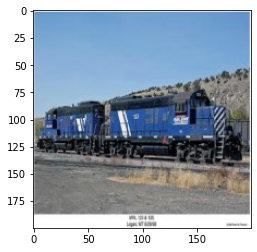

In [71]:
plt.imshow(_A)

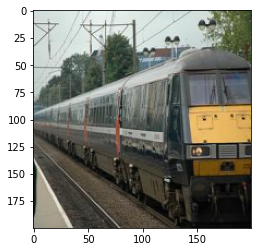

In [72]:
plt.imshow(_B)

In [73]:
correlations, inlier_matching, inlier_count = cnnalign(A,B)

(1, 625, 25, 25, 2)


In [74]:
inlier_count

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1347.2731], dtype=float32)>

In [ ]:
pf_pascal = PF_Pascal("/home/files/datasets/PF-dataset-PASCAL")

In [ ]:
ds = pf_pascal.dataset_loader("categorical_pair")

In [ ]:
for i,j in ds.take(10):
    print(i.shape, j.shape)

In [ ]:
def draw_matches(img1, img2, map_size, coords):
    H1, W1, C = img1.shape
    H2, W2, C = img2.shape
    campus = np.zeros([H1, W1+W2, C])
    campus[:H1,:W1] = img1
    campus[:H2,W1:W1+W2] = img2
    
    
    def cal_keypoints_positions(coord):
        mH, mW = map_size
        grid_H, grid_W = H1/mH, W1/mW
        img1_x, img1_y = grid_W*coord[1]+grid_W*0.5, grid_H*coord[0]+grid_H*0.5
        img2_x, img2_y = grid_W*coord[1]+grid_W*0.5, grid_H*coord[0]+grid_H*0.5
        img2_x = img2_x + W1
        return int(img1_x), int(img1_y), int(img2_x), int(img2_y)
    
    for coord in coords:
        img1_x, img1_y, img2_x, img2_y = cal_keypoints_positions(coord)    
        campus = cv2.line(campus, (img1_x,img1_y), (img2_x,img2_y), (0,255,0), 2)
    
    return campus

In [ ]:
img1, img2 = A[0].numpy(), B[0].numpy()
img1, img2 = restore_original_image_from_array(img1)/255., restore_original_image_from_array(img2)/255.

In [ ]:
fig = plt.figure(figsize=(20, 40))
for i, (img1, img2) in enumerate(zip(A,B)):
    img1, img2 = img1.numpy(), img2.numpy()
    img1, img2 = restore_original_image_from_array(img1)/255., restore_original_image_from_array(img2)/255.
    coords = matches[matches[:,0]==i][:,1:]
    campus = draw_matches(img1, img2, (25,25), coords.numpy())
    fig.add_subplot(10,1,i+1).imshow(campus)
plt.show()